# Modelo K-Means Dataset Mall Customer
## Wilder Araque Caicedo
### Análisis de Datos
### UNAD

In [48]:
#Importar librerías 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')


In [8]:
# Cargue del dataset Mall_Customers.csv desde ruta del notebook
MallCustomer = pd.read_csv('Mall_Customers.csv')
# Cargue de la información del dataset
MallCustomer.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
MallCustomer.shape

(200, 5)

In [16]:
# Estadísticas descriptivas
MallCustomer.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [18]:
# Identificar valores nulos
print("Valores nulos:\n", MallCustomer.isnull().sum())

Valores nulos:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


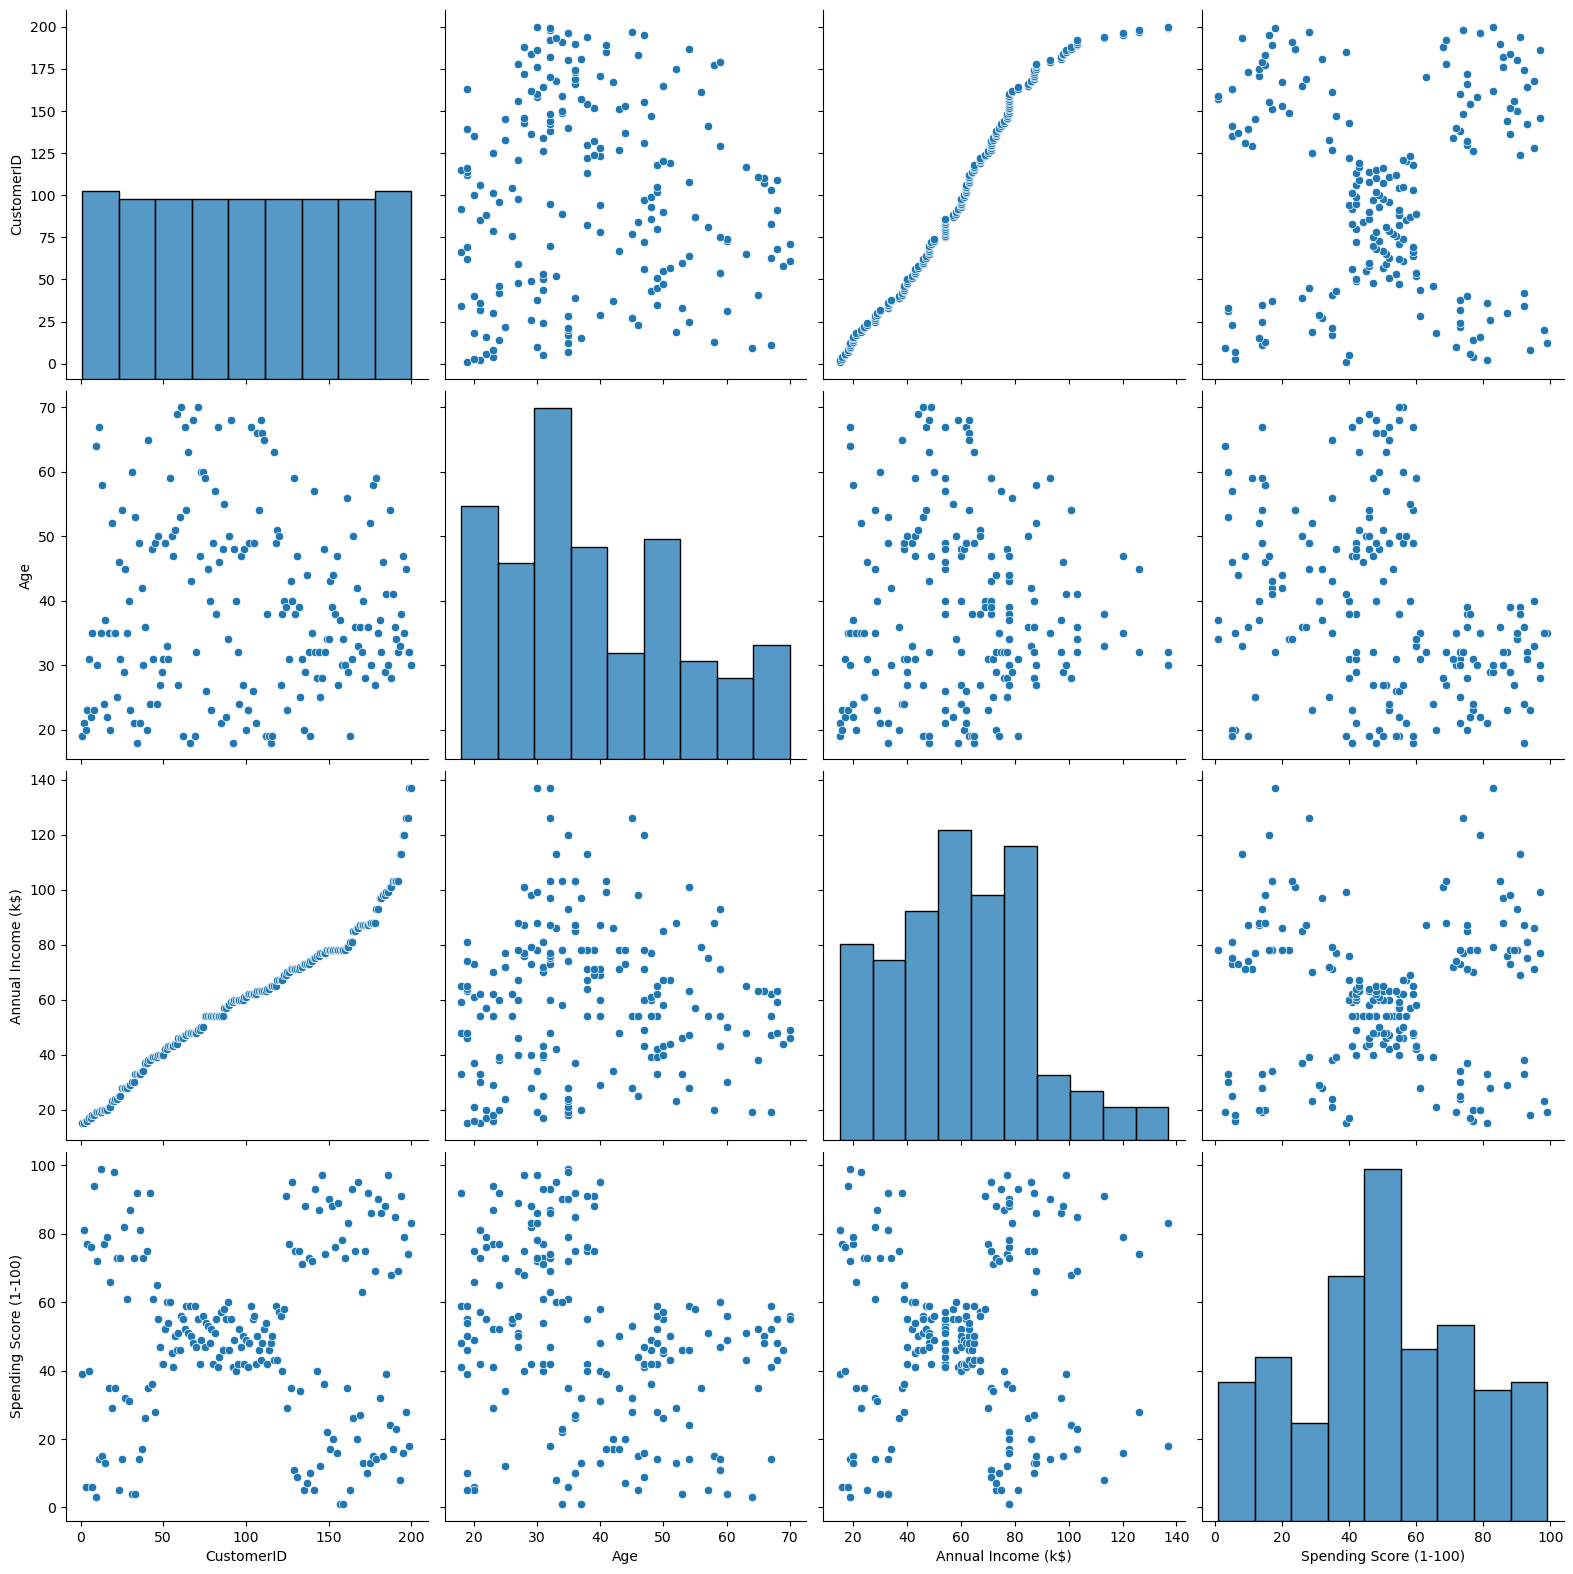

In [28]:
# Visualizaciones básicas de las relaciones y distribuciones entre variables
sns.pairplot(MallCustomer.dropna(), size=4,kind='scatter')

In [30]:
# Renombrar columnas en valores numéricos para facilitar su uso 
MallCustomer.columns = ['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score']

# Convertir género en variable numérica
MallCustomer['Gender'] = MallCustomer['Gender'].map({'Male': 0, 'Female': 1})

# Seleccionar las columnas relevantes (descartando 'CustomerID')
features = MallCustomer[['Gender', 'Age', 'Annual_Income', 'Spending_Score']]

In [32]:
# Matriz de correlación
corr_matrix = MallCustomer.corr()
corr_matrix

,CustomerID,Gender,Age,Annual_Income,Spending_Score
CustomerID,1.000000,-0.057400,-0.026763,0.977548,0.013835
Gender,-0.057400,1.000000,-0.060867,-0.056410,0.058109
Age,-0.026763,-0.060867,1.000000,-0.012398,-0.327227
Annual_Income,0.977548,-0.056410,-0.012398,1.000000,0.009903
Spending_Score,0.013835,0.058109,-0.327227,0.009903,1.000000


In [36]:
# Escalado de los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Verificación de los datos escalados
pd.DataFrame(scaled_features, columns=features.columns).head()

,Gender,Age,Annual_Income,Spending_Score
0,-1.128152,-1.424569,-1.738999,-0.434801
1,-1.128152,-1.281035,-1.738999,1.195704
2,0.886405,-1.352802,-1.700830,-1.715913
3,0.886405,-1.137502,-1.700830,1.040418
4,0.886405,-0.563369,-1.662660,-0.395980


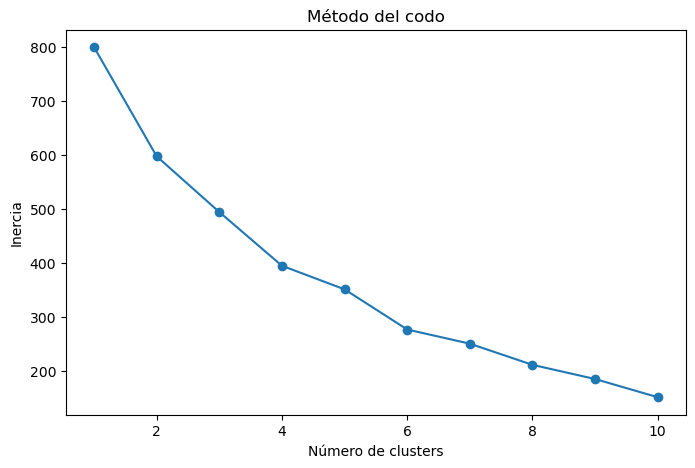

In [38]:
# Encontrar el número óptimo de clusters usando el método del codo
inertia = []
range_n_clusters = range(1, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Visualización del método del codo
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

In [50]:
# Selección de 4 como el número óptimo de clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_features)

# Métricas de evaluación
silhouette_avg = silhouette_score(scaled_features, labels)
calinski_harabasz = calinski_harabasz_score(scaled_features, labels)

print(f"Silhouette Coefficient: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Coefficient: 0.29010917402310876
Calinski-Harabasz Index: 66.85612604777728


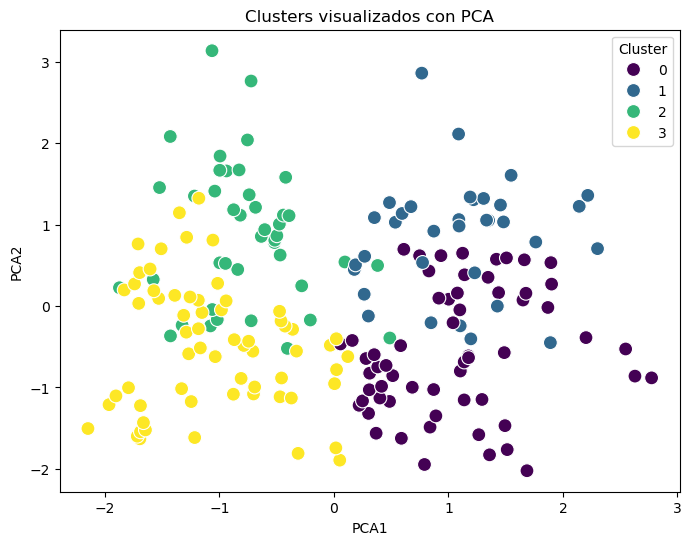

In [54]:
# Añadir las etiquetas a los datos originales para la visualización de resultados
MallCustomer['Cluster'] = labels

# Visualización 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
reduced_data = pd.DataFrame(reduced_features, columns=['PCA1', 'PCA2'])
reduced_data['Cluster'] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=reduced_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('Clusters visualizados con PCA')
plt.show()

In [56]:
# Resumen por cluster
cluster_summary = MallCustomer.groupby('Cluster').mean()
print(cluster_summary)

         CustomerID    Gender        Age  Annual_Income  Spending_Score
Cluster                                                                
0         67.783333  0.566667  54.700000      46.900000       39.933333
1        164.529412  0.411765  41.264706      88.500000       16.764706
2        100.809524  0.000000  28.690476      60.904762       70.238095
3         96.953125  1.000000  29.375000      58.296875       64.437500


In [66]:
# Cálculo del coeficiente de correlación cofenética

# Selección de las columnas género, edad e ingresos anuales
X = MallCustomer[['Gender', 'Age', 'Annual_Income']].values  

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Calcular distancias y matriz de enlace
X_dist = pdist(X)  # Cálculo de distancias
Z = linkage(X, method='ward')  # Cálculo de la matriz de enlace

# Calcular coeficiente cofenético
coef_cofenetico, _ = cophenet(Z, X_dist)
print("Coeficiente de correlación cofenética:", coef_cofenetico)

Coeficiente de correlación cofenética: 0.6922360539404938
